In [1]:
"""
Analyse merged data from EU database (output from 1_2-prep_database_file_merger)
For now we only use *.csv export from EU database
"""

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline
from config import MERGED_DATA_FILE, DATABASE_FILE_DTYPES, DATABASE_FILE_INDEX, UNIQUE_VALUES_THRESHOLD, OUTPUT_DIR

In [2]:
df = pd.read_csv(MERGED_DATA_FILE, dtype=DATABASE_FILE_DTYPES, index_col=DATABASE_FILE_INDEX)

In [3]:
print(f"Dimension: {df.shape}")
print(f"Columns: {df.columns}")
print(f"Data types:\n{df.dtypes}")

Dimension: (30134420, 18)
Columns: Index(['member_state', 'manufacturer_name_eu', 'vehicle_type',
       'commercial_name', 'category_of_vehicle', 'fuel_type', 'fuel_mode',
       'innovative_technologies', 'mass_vehicle', 'weltp_test_mass',
       'engine_capacity', 'engine_power', 'erwltp', 'year', 'electric_range',
       'electric_energy_consumption', 'fuel_consumption',
       'specific_co2_emissions'],
      dtype='object')
Data types:
member_state                    object
manufacturer_name_eu            object
vehicle_type                    object
commercial_name                 object
category_of_vehicle             object
fuel_type                       object
fuel_mode                       object
innovative_technologies         object
mass_vehicle                   float64
weltp_test_mass                float64
engine_capacity                float64
engine_power                   float64
erwltp                         float64
year                             int64
electric

In [4]:
df.head(2)

,member_state,manufacturer_name_eu,vehicle_type,commercial_name,category_of_vehicle,fuel_type,fuel_mode,innovative_technologies,mass_vehicle,weltp_test_mass,engine_capacity,engine_power,erwltp,year,electric_range,electric_energy_consumption,fuel_consumption,specific_co2_emissions
ID,,,,,,,,,,,,,,,,,,
56002959,GR,HYUNDAI,OS,"KONA,KAUAI",M1,DIESEL,M,NaN,1415.0,1600.0,1598.0,100.0,NaN,2021,NaN,NaN,NaN,127.0
56002960,GR,HYUNDAI,OS,"KONA,KAUAI",M1,DIESEL,M,NaN,1415.0,1600.0,1598.0,100.0,NaN,2021,NaN,NaN,NaN,127.0


In [5]:
print("Missing percentages:")
print(df.isna().sum() / len(df))

Missing percentages:
member_state                   0.000000
manufacturer_name_eu           0.000000
vehicle_type                   0.000429
commercial_name                0.003110
category_of_vehicle            0.001289
fuel_type                      0.000000
fuel_mode                      0.000007
innovative_technologies        0.376596
mass_vehicle                   0.000015
weltp_test_mass                0.012037
engine_capacity                0.131065
engine_power                   0.010614
erwltp                         0.383882
year                           0.000000
electric_range                 0.799314
electric_energy_consumption    0.789126
fuel_consumption               0.207794
specific_co2_emissions         0.001166
dtype: float64


In [6]:
# df["Cn"].value_counts()
# len(df["Mk"].unique())
# df["Mh"].unique()
# len(df["T"].unique())
# len(df["Ct"].unique())

## Analyze categorical variables

* check unique values
* check distribution

For now we want to start simple and restrictive. Because of this we will remove variables with an unique value count higher than UNIQUE_VALUES_THRESHOLD. 

In case we consider innovative_technologies for the future: 
* innovative_technologies
    * try to get an understanding what is behind such abbreviations
    * e13 29 could mean e13, e29 -> in that case we'd need to think about a way to split values, maybe encoding is a good idea -> ask Romain

In [7]:
cat_vars = df.select_dtypes(include="object")

In [8]:
# distribution
for col in cat_vars:
    print(f"----{col}----")
    print(cat_vars[col].value_counts())

----member_state----
member_state
DE    7866301
FR    5306356
IT    4333314
ES    2733515
PL    1331025
BE    1227594
NL     986127
SE     873828
AT     692003
CZ     604021
PT     500528
DK     500028
NO     476890
RO     394098
GR     339541
HU     330355
IE     329669
FI     259722
SK     242019
HR     146168
SI     145496
LU     128423
BG      89692
LT      82866
EE      65382
LV      48718
IS      46257
CY      36205
MT      18279
Name: count, dtype: int64
----manufacturer_name_eu----
manufacturer_name_eu
VOLKSWAGEN          3251804
RENAULT             2322989
BMW AG              1987623
STELLANTIS AUTO     1745847
MERCEDES-BENZ AG    1696326
                     ...   
UAZ                       3
ADIDOR                    2
LEVC                      2
LEEH                      2
HUNAN JIANGNAN            1
Name: count, Length: 122, dtype: int64
----vehicle_type----
vehicle_type
U                                 1883668
312                                817582
DJF                

In [9]:
cols_to_drop = list()
# unique values
for col in cat_vars:
    print(f"----{col}----")
    print(f"Number of unique values: {len(cat_vars[col].unique())}")
    print(cat_vars[col].unique())
    if len(cat_vars[col].unique()) > UNIQUE_VALUES_THRESHOLD:
        cols_to_drop.append(col)

print(f"Columns to drop: {cols_to_drop}")

----member_state----
Number of unique values: 29
['GR' 'FR' 'SE' 'RO' 'BG' 'EE' 'LU' 'IT' 'DK' 'LT' 'LV' 'DE' 'ES' 'HR'
 'HU' 'FI' 'CZ' 'AT' 'BE' 'MT' 'PL' 'NO' 'IE' 'SI' 'PT' 'NL' 'IS' 'CY'
 'SK']
----manufacturer_name_eu----
Number of unique values: 122
['HYUNDAI' 'TOYOTA' 'FIAT GROUP' 'KIA' 'HYUNDAI ASSAN' 'VOLVO' 'LANZHOU'
 'TESLA' 'MITSUBISHI MOTORS THAILAND' 'BENTLEY'
 'JAGUAR LAND ROVER LIMITED' 'MORGAN' 'HYUNDAI CZECH'
 'NISSAN AUTOMOTIVE EUROPE' 'HONDA MOTOR CO' 'SKODA' 'MAGYAR SUZUKI'
 'AUDI HUNGARIA' 'RENAULT' 'DACIA' 'KIA SLOVAKIA' 'AUTOMOBILES PEUGEOT'
 'AUTOMOBILES CITROEN' 'PSA' 'DUPLICATE' 'ALPINE' 'SECMA' 'AA-IVA'
 'VOLKSWAGEN' 'OUT OF SCOPE' 'CHRYSLER' 'FORD MOTOR COMPANY'
 'GENERAL MOTORS HOLDINGS' 'MAZDA' 'SUBARU' 'MAZDA EUROPE'
 'MITSUBISHI MOTORS CORPORATION' 'SUZUKI MOTOR CORPORATION'
 'TOYOTA MOTOR CORPORATION' 'GEELY' 'POLESTAR' 'ALFA ROMEO' 'FERRARI'
 'LAMBORGHINI' 'MASERATI' 'AUDI AG' 'OPEL AUTOMOBILE' 'BMW AG' 'BMW GMBH'
 'MERCEDES-BENZ AG' 'FORD WERKE GMBH'

['member_state', 'manufacturer_name_eu', 'vehicle_type', 'commercial_name', 'innovative_technologies']
Would need proper cleaning to make them usable. If we reconsider using them we can do the following:
- merge unique_vals with low count into combined class
- merge similar unique_vals into combined classes

In [10]:
# Drop columns with too many unique values
df.drop(columns=cols_to_drop, inplace=True)
# refresh cat_vars as df has changed
cat_vars = df.select_dtypes(include="object")

Text(0.5, 1.0, 'Distribution of Fuel Types')

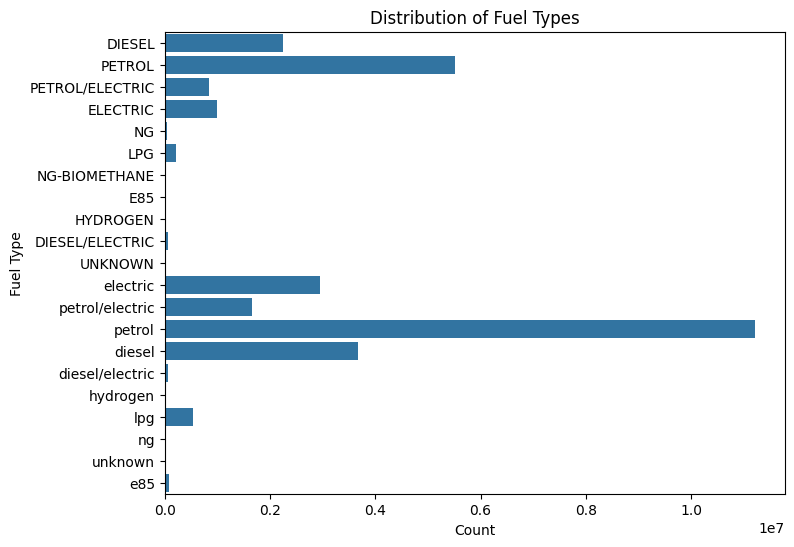

In [11]:
plt.figure(figsize=(8, 6))
sns.countplot(y="fuel_type", data=df)

plt.xlabel("Count")
plt.ylabel("Fuel Type")
plt.title("Distribution of Fuel Types")

Text(0.5, 1.0, 'Potential relationship of fuel_type to fuel_consumption')

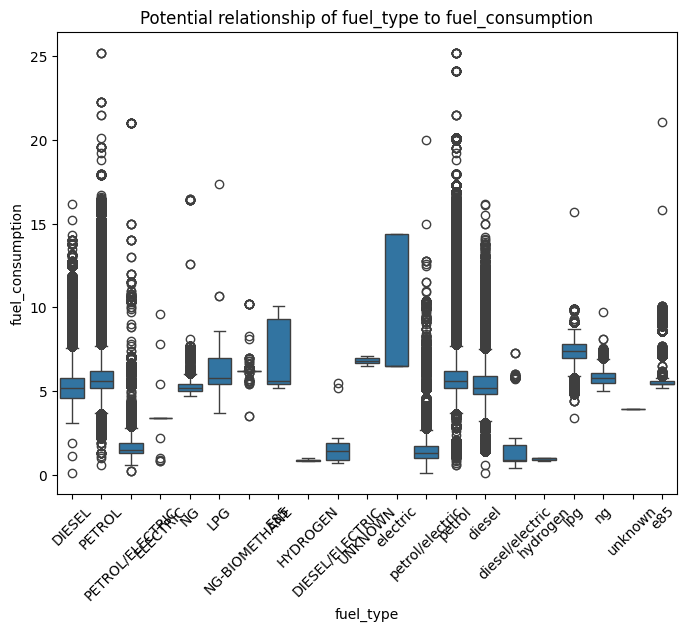

In [12]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="fuel_type", y="fuel_consumption", data=df)

plt.xticks(rotation=45)
plt.xlabel("fuel_type")
plt.ylabel("fuel_consumption")
plt.title("Potential relationship of fuel_type to fuel_consumption")

Text(0.5, 1.0, 'Potential relationship of fuel_type to specific_co2_emissions')

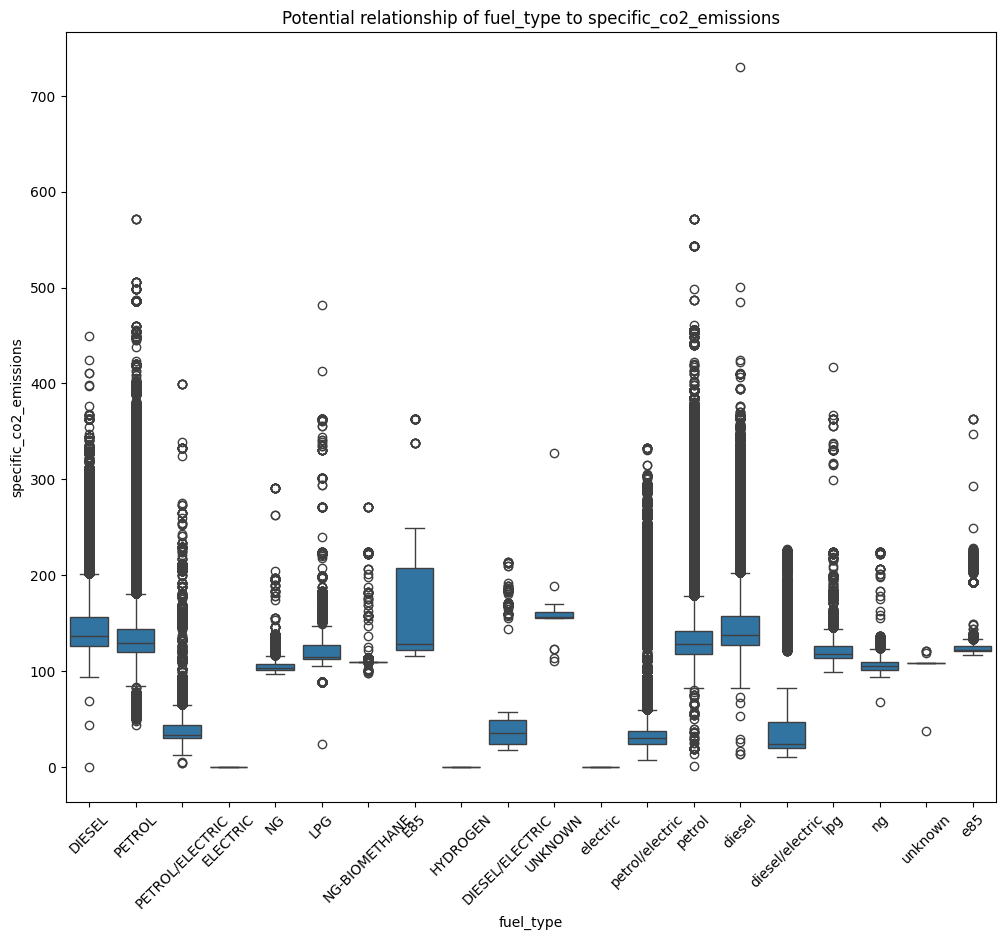

In [30]:
plt.figure(figsize=(12, 10))
sns.boxplot(x="fuel_type", y="specific_co2_emissions", data=df)


plt.xticks(rotation=45)
plt.xlabel("fuel_type")
plt.ylabel("specific_co2_emissions")
plt.title("Potential relationship of fuel_type to specific_co2_emissions")

---> specific_co2_emissions for fuel_type electric and hydrogen are always 0
* check fuel_type electric against electric_energy_consumption

Text(0.5, 1.0, 'Potential relationship of electric fuel_type to electric_energy_consumption')

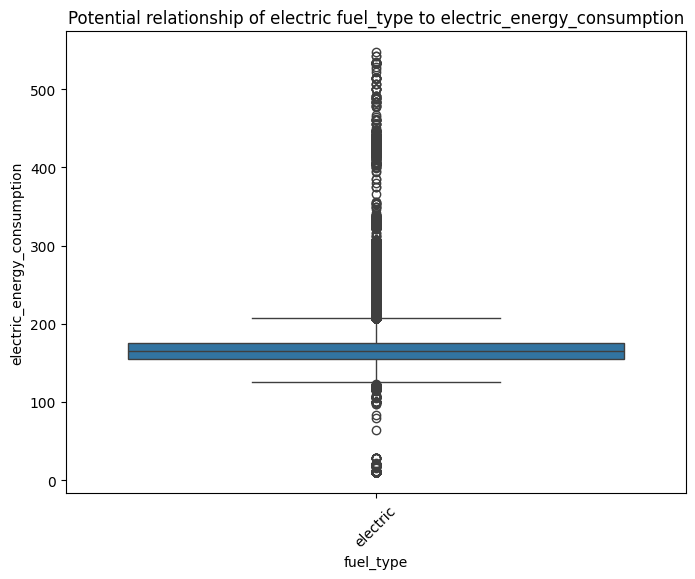

In [14]:
# take a deeper look into df_electric
df_electric = df[df["fuel_type"] == "electric"]


plt.figure(figsize=(8, 6))
sns.boxplot(x="fuel_type", y="electric_energy_consumption", data=df_electric)

plt.xticks(rotation=45)
plt.xlabel("fuel_type")
plt.ylabel("electric_energy_consumption")
plt.title("Potential relationship of electric fuel_type to electric_energy_consumption")

In [15]:
# check how many cars have fuel_type hydroen
hydrogen_count = len(df[df["fuel_type"] == "hydrogen"])
print(f"{hydrogen_count} cars with fuel_type hydrogen")

1968 cars with fuel_type hydrogen


Remove hydrogen cars from our df as they are not representative

In [16]:
# drop rows with df["fuel_type"] == "hydrogen"
df = df[df["fuel_type"] != "hydrogen"]

## Split dataset into dataframe fuel type electric and dataframe with fuel types belonging to combustion engine category

### Cars with fuel_type electric

In [17]:
# check missing percentages of df_electric
print("Missing percentage for fuel_type == electric:")
print(df_electric.isna().sum() / len(df_electric))

Missing percentage for fuel_type == electric:
member_state                   0.000000
category_of_vehicle            0.004936
fuel_type                      0.000000
fuel_mode                      0.000000
mass_vehicle                   0.000021
weltp_test_mass                0.055303
engine_capacity                1.000000
engine_power                   0.058351
erwltp                         1.000000
year                           0.000000
electric_range                 0.091623
electric_energy_consumption    0.023507
fuel_consumption               0.999989
specific_co2_emissions         0.000003
dtype: float64


Remove variables that are useful for df_electric

In [18]:
df_electric["fuel_mode"].value_counts(normalize=True)


fuel_mode
E    1.0
Name: proportion, dtype: float64

In [19]:
# "fuel_type" not needed anymore as we only have fuel_type electric for now, same with fuel_mode
columns_to_analyse = ["category_of_vehicle", "mass_vehicle", "engine_power", "year", "electric_energy_consumption", "electric_range"]
df_electric = df_electric[columns_to_analyse]

#### Encoding

In [20]:
# encoding of categorical vars
cat_columns = pd.DataFrame.select_dtypes(df_electric, include=["object"]).columns
quant_columns = df_electric.select_dtypes(exclude=["object"]).columns

ct_electric = ColumnTransformer(transformers=[("encoder", OneHotEncoder(), cat_columns)], remainder="passthrough")
transformed_array = ct_electric.fit_transform(df_electric)
encoder_feature_names = ct_electric.named_transformers_["encoder"].get_feature_names_out(cat_columns)

preserved_col_names = list(encoder_feature_names)
preserved_col_names.extend(list(quant_columns))

df_electric = pd.DataFrame(transformed_array, columns=preserved_col_names)

#### Calculate and analyse correlations

<Axes: >

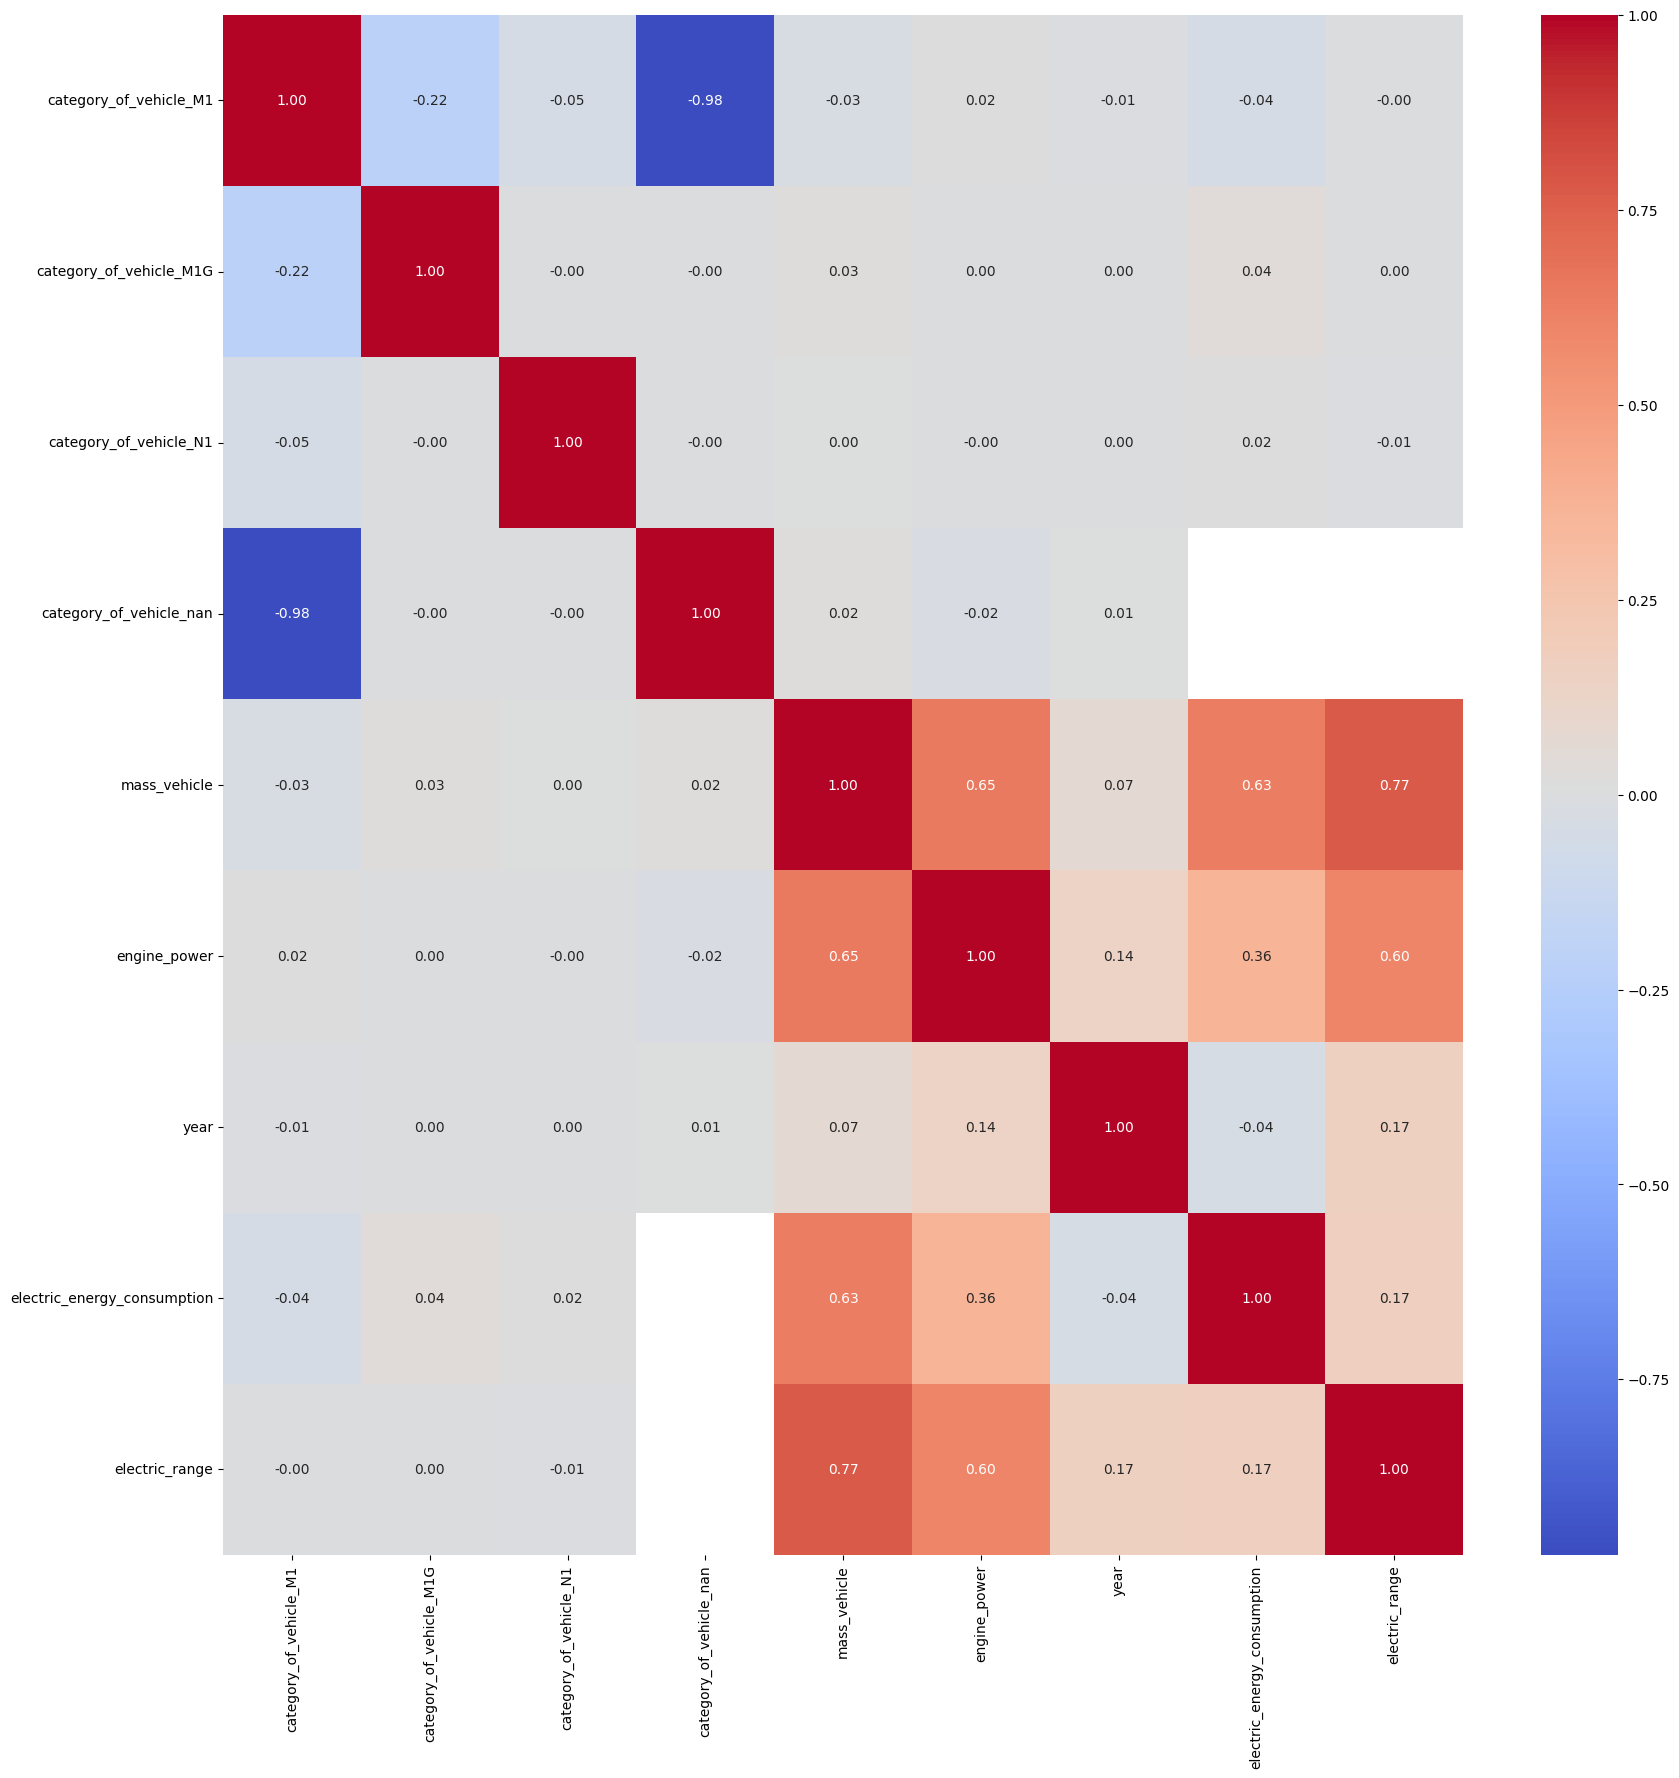

In [21]:
corr_matrix_electric = df_electric.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix_electric, annot=True, cmap="coolwarm", fmt=".2f")

In [22]:
# check against target electric_energy_consumption
corr_table = df_electric.corr()["electric_energy_consumption"].sort_values(ascending=False)
print(corr_table)
export_path = OUTPUT_DIR + "/corr_table_electric_energy_consumption.csv"
corr_table.to_csv(export_path)

electric_energy_consumption    1.000000
mass_vehicle                   0.634259
engine_power                   0.364502
electric_range                 0.169400
category_of_vehicle_M1G        0.040563
category_of_vehicle_N1         0.018697
year                          -0.040972
category_of_vehicle_M1        -0.043814
category_of_vehicle_nan             NaN
Name: electric_energy_consumption, dtype: float64


### Cars with fuel_type belonging to combustion category

> All cars that are not electric
>
> consider hybrid petrol/electric and diesel/electric to belong to combustion category

In [23]:
# MAKE SURE to update fuel_types if other datasets have types we did not consider.
combustion_fuel_types = ["petrol", "diesel", "petrol/electric", "lpg", "e85", "diesel/electric", "ng"]
df_combustion = df[df["fuel_type"].isin(combustion_fuel_types)]

In [24]:
# check missing percentages of df_combustion
print("Missing percentage for fuel_type belonging to combustion:")
print(df_combustion.isna().sum() / len(df_combustion))

Missing percentage for fuel_type belonging to combustion:
member_state                   0.000000
category_of_vehicle            0.000767
fuel_type                      0.000000
fuel_mode                      0.000000
mass_vehicle                   0.000009
weltp_test_mass                0.009686
engine_capacity                0.000009
engine_power                   0.000457
erwltp                         0.238458
year                           0.000000
electric_range                 0.902996
electric_energy_consumption    0.901575
fuel_consumption               0.019660
specific_co2_emissions         0.001256
dtype: float64


Remove variables that are useful for df_combustion

In [25]:
columns_to_analyse = ["category_of_vehicle", "fuel_type", "mass_vehicle", "engine_capacity", "engine_power", "year", "fuel_consumption"]
df_combustion = df_combustion[columns_to_analyse]

#### Encoding

In [26]:
# encoding of categorical vars
cat_columns = pd.DataFrame.select_dtypes(df_combustion, include=["object"]).columns
quant_columns = df_combustion.select_dtypes(exclude=["object"]).columns

ct_combustion = ColumnTransformer(transformers=[("encoder", OneHotEncoder(), cat_columns)], remainder="passthrough")
transformed_array = ct_combustion.fit_transform(df_combustion)
encoder_feature_names = ct_combustion.named_transformers_["encoder"].get_feature_names_out(cat_columns)

preserved_col_names = list(encoder_feature_names)
preserved_col_names.extend(list(quant_columns))

df_combustion = pd.DataFrame(transformed_array, columns=preserved_col_names)

#### Calculate and analyse correlations

<Axes: >

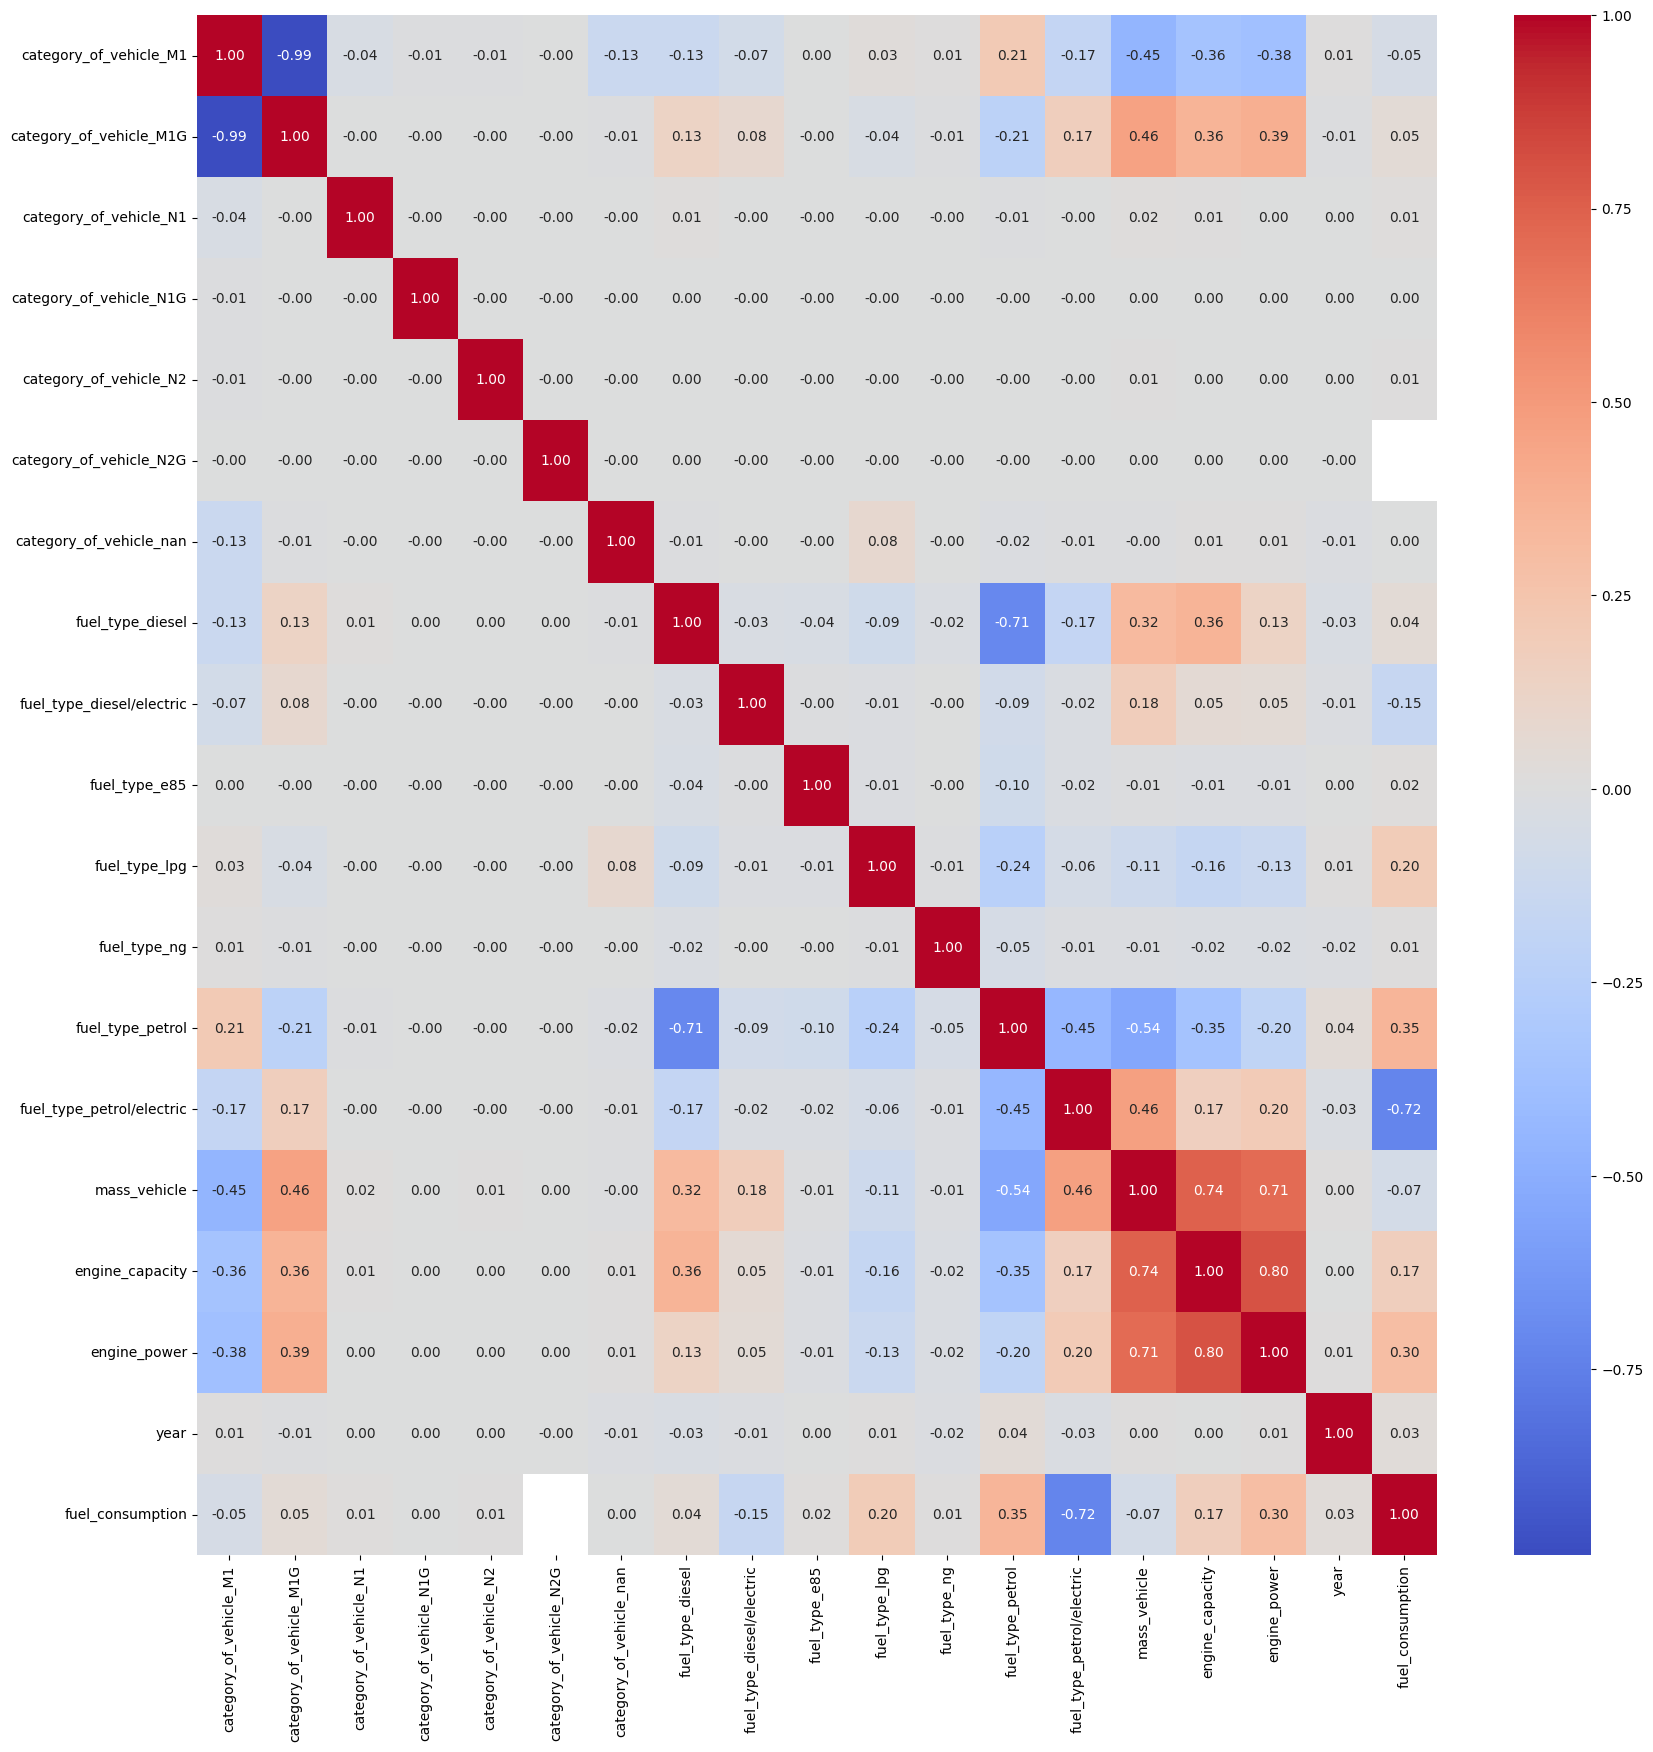

In [27]:
corr_matrix_combustion = df_combustion.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix_combustion, annot=True, cmap="coolwarm", fmt=".2f")

In [28]:
# check against target fuel_consumption
corr_table = df_combustion.corr()["fuel_consumption"].sort_values(ascending=False)
print(corr_table)
export_path = OUTPUT_DIR + "/corr_table_fuel_consumption.csv"
corr_table.to_csv(export_path)

fuel_consumption             1.000000
fuel_type_petrol             0.351093
engine_power                 0.298553
fuel_type_lpg                0.196072
engine_capacity              0.168373
category_of_vehicle_M1G      0.050128
fuel_type_diesel             0.044111
year                         0.030144
fuel_type_e85                0.016823
category_of_vehicle_N1       0.014100
fuel_type_ng                 0.008582
category_of_vehicle_N2       0.006700
category_of_vehicle_N1G      0.002397
category_of_vehicle_nan      0.002131
category_of_vehicle_M1      -0.050707
mass_vehicle                -0.067295
fuel_type_diesel/electric   -0.151155
fuel_type_petrol/electric   -0.721445
category_of_vehicle_N2G           NaN
Name: fuel_consumption, dtype: float64
